<a href="https://colab.research.google.com/github/BeardMaster/flatland/blob/main/Flatland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [343]:
%matplotlib inline

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, \
                                    Activation, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from IPython.display import YouTubeVideo
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import math



# Data load

In [342]:
data = np.load('/content/drive/MyDrive/Colab Notebooks/flatland_train.npz')

X = data['X']
y = data['y']



In [344]:
indices_to_remove=[19, 529, 563, 597, 619, 1403, 1442, 1598, 1748, 1854, 2148, 2226, 2345, 2721, 2748, 3029, 3062, 3357, 3431, 3441, 3798, 3988, 4037, 4068
 , 4168, 4243, 4402, 4452, 4645, 4659, 4804, 4907, 5083, 5130, 5333, 6131, 6155, 6162, 6317, 6517, 6670, 6942, 7093, 7220, 7490, 7575, 7601, 7655,
 7806, 7983, 8068, 8613, 9495, 9664, 9704, 9718, 5029, 5852, 6966, 7291, 8580, 9142, 5028, 5850, 5872, 6636, 1233, 1467, 2095, 2663, 2963, 4040, 4456, 4785,
  5535, 7904, 2092, 2958, 4034, 4449, 4777, 5003, 5525, 5860, 7889, 8653, 691, 2955, 4030, 4444, 4771, 5517, 5851, 6161, 6614, 7879, 8642, 5012, 6941,
  8554, 9114, 1962, 6314, 8110, 8281, 504, 3118, 5323, 6496, 6711, 9007, 2088, 4438, 5507, 6599, 7861, 8620, 9458,
  3082, 5004, 8533, 9090, 673, 2729, 2790, 3064, 3769, 4232, 4442, 8484, 8529, 8815,
  2726, 2786, 3058, 4224, 4245, 4432, 5351, 5925, 7456, 1229, 1462, 4018, 4977, 5828, 6586, 7009, 7847, 8602, 9217,
  1228, 1460, 2651, 4012, 4063, 5484, 6572, 6994, 7830, 8584, 9418, 688, 2258, 3071, 4983, 5794, 5871, 6352, 6567, 6897, 7223, 8497, 9052,
  2782, 3053, 3209, 4216, 4237, 4423, 5340, 5912, 6547, 7440, 8450, 8493, 9688,503, 876, 1377, 1645, 2161, 2203, 2577,
  2946, 3849, 4956, 5292, 5951, 5974, 6457, 6668, 8947,1460, 2651, 5484, 6572, 6994, 7830, 9418, 688, 4983,
                   6352, 7223, 8497, 9052, 672, 2782, 3053, 3757, 4216, 4423, 5340, 5912, 7440, 8450, 8493, 1453, 2638, 4041, 4394, 4720, 5454, 6531, 6951, 7784, 8534, 3745, 6655, 111

                   ]
len(indices_to_remove)
 # Create a mask with True for indices we want to keep
mask = np.ones(len(y), dtype=bool)
mask[indices_to_remove] = False

# Apply the mask
X = X[mask]
y= y[mask]

In [ ]:
X.shape
y.shape


(9795,)

In [345]:


y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X / 255.      # Scale down to range [0, 1]


In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [367]:


# Specify classes and size of subset
classes_of_interest = [0, 1, 2, 3, 4 ]
n = 200  # Number of samples to add

# Filter, sample, and rotate images
rotated_images = []
rotated_labels = []
for class_label in classes_of_interest:
    class_indices = np.where(y_train == class_label)[0]
    sampled_indices = np.random.choice(class_indices, size=min(n, len(class_indices)), replace=False)
    print(class_indices.size)
    for idx in sampled_indices:
        # Rotate image and add to list
        rotated_image = np.rot90(X_train[idx], k=1)  # 90 degree rotation
        rotated_images.append(rotated_image)
        rotated_labels.append(class_label)

# Convert lists to NumPy arrays
rotated_images = np.array(rotated_images)
rotated_labels = np.array(rotated_labels)
# rotated_images.size
# # Concatenate rotated images and labels to the training dataset
X_train = np.concatenate((X_train, rotated_images), axis=0)
y_train = np.concatenate((y_train, rotated_labels))

# # Checking the results
# print(f"X_train_augmented shape: {X_train_augmented.shape}, y_train_augmented shape: {y_train_augmented.shape}")



1264
2236
1479
1857
1789


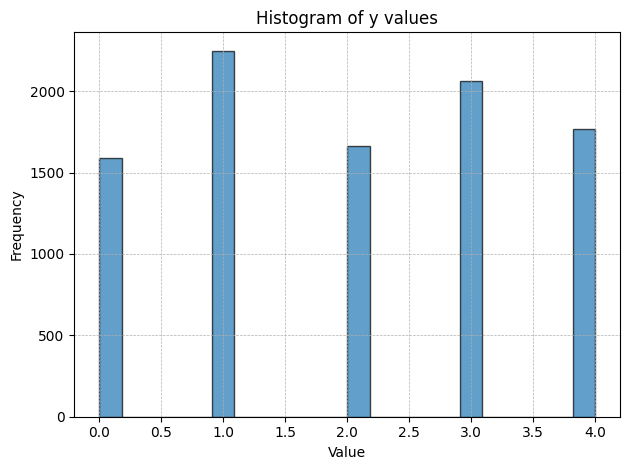

In [ ]:
# Create a histogram of y values
plt.hist(y_train, bins='auto', edgecolor='black', alpha=0.7)
plt.title('Histogram of y values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# preproc

In [ ]:
def plot(X):
    plt.imshow(X, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

def apply_filter(X, F):
    x, y = X.shape
    filter_x, filter_y = F.shape
    X_with_filter = np.zeros(shape=(x - filter_x, y - filter_y))

    for i in range(x - filter_x):
        for j in range(y - filter_y):
            X_with_filter[i, j] = (X[i:(i+filter_x), j:(j+filter_y)] * F).sum()

    return X_with_filter

In [ ]:
def pad_n(X, n):
  padded = np.pad(X, [n, n], mode="constant")
  return padded

In [ ]:
def sum_disk(M):
  X = pad_n(M,3)
  x, y = X.shape
  X_disk_counted=np.zeros(shape=M.shape)

  F = np.array([
              [-10, -5, -5, -1, -5, -5, -10],
              [-5, -10, 0, 0, 0, -10, -5],
              [-5, 0, 10, 10, 10, 0, -5],
              [-1, 0, 10, 30, 10, 0, -1],
              [-5, 0, 10, 10, 10, 0, -5],
              [-5, -10, 0, 0, 0, -10, -5],
              [-10, -5, -5, -1, -5, -5, -10]
              ])


  # print(X.shape)
  F_norm=F.sum()
  for i in range(3, x - 4):
        for j in range(3, y - 4):
            X_disk_counted[i-3, j-3] = (X[(i-3):(i+4), (j-3):(j+4)] * F).sum()/F_norm
  return X_disk_counted



In [ ]:
def filter(X, k):
  return (1/k)*np.where(X<k, X, 0)

In [ ]:
def numpy_preprocessing(X):
  # F = np.array([[-1, -1, -1 , -1],
  #             [ -1,  1.5,  1.5, -1],
  #             [ -1,  1.5,  1.5, -1],
  #             [-1, -1, -1, -1]])
  X_proc=np.zeros((X.shape[0], X.shape[1]+12, X.shape[2]+12))
  for i in range(len(X)):
    # T=apply_filter( np.pad(filter(sum_disk(X[i]), 0.01), ([0,4],[0,4]), mode="constant"), F)
    # scale=np.min(T)
    # scaled = (1/scale)*T
    X_proc[i]= pad_n(X[i],6)
  return  X_proc.reshape(X_proc.shape[0], X_proc.shape[1], X_proc.shape[2], 1)
  # return  X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

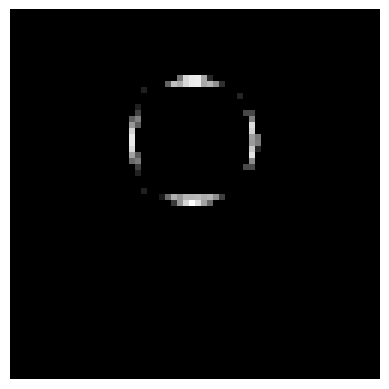

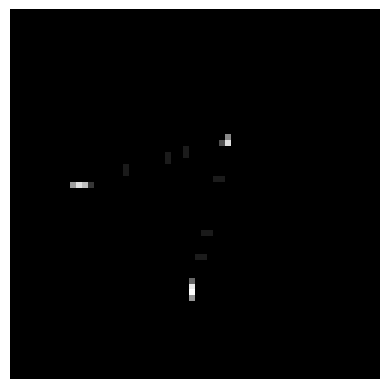

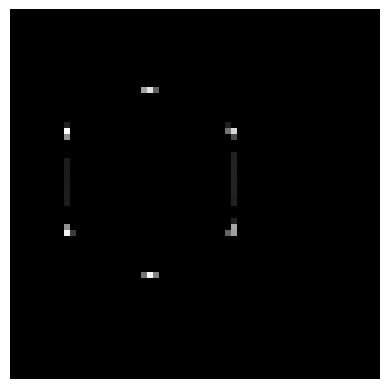

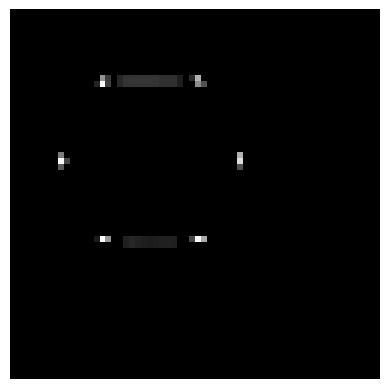

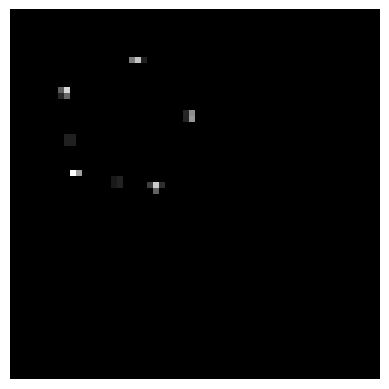

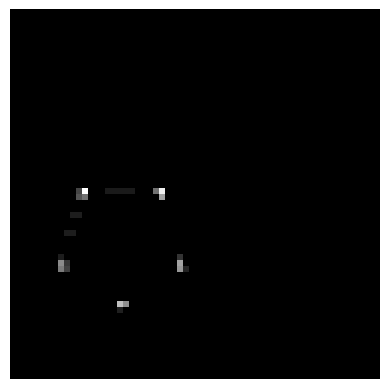

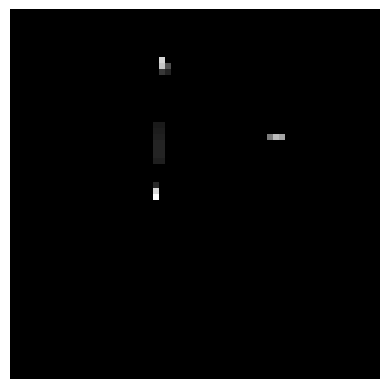

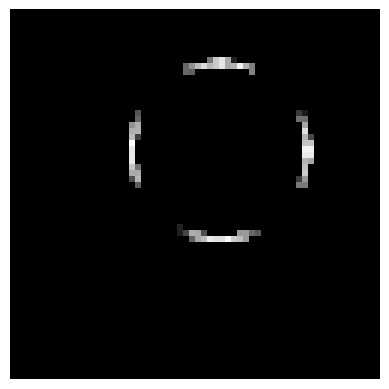

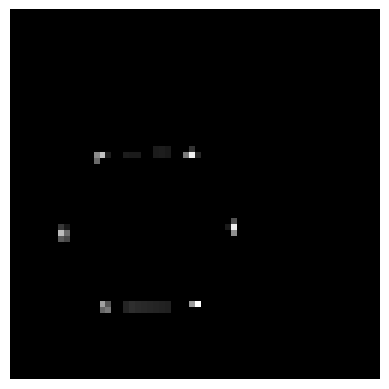

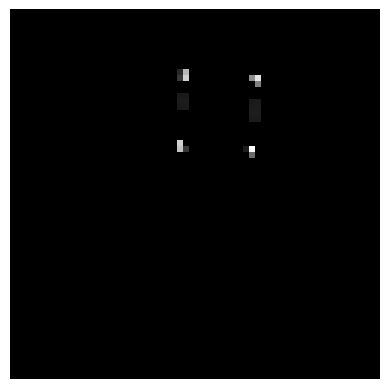

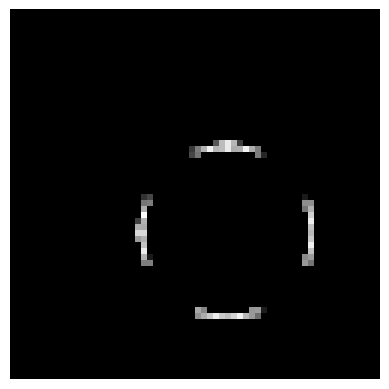

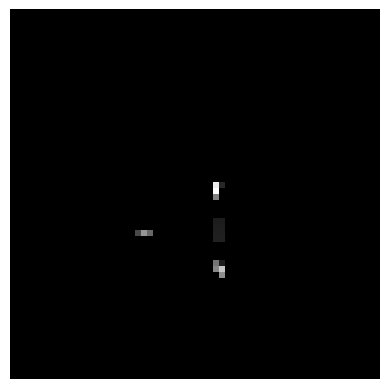

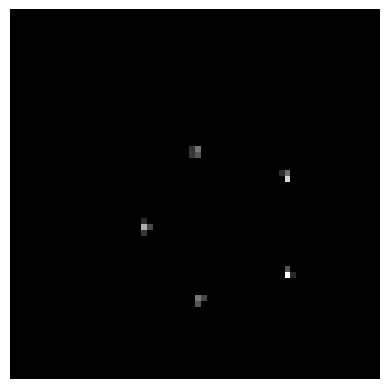

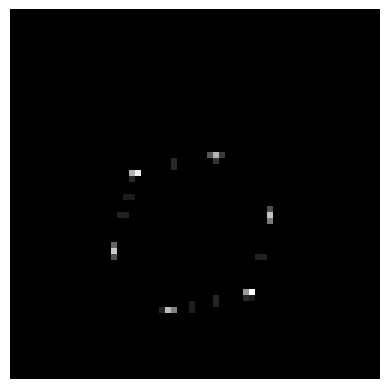

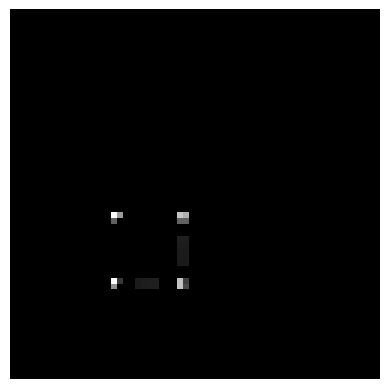

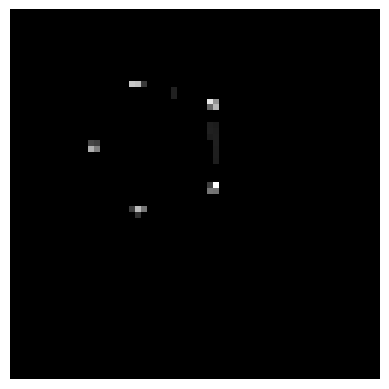

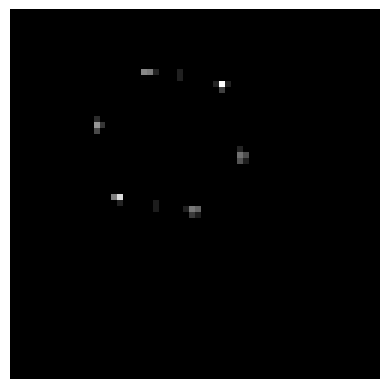

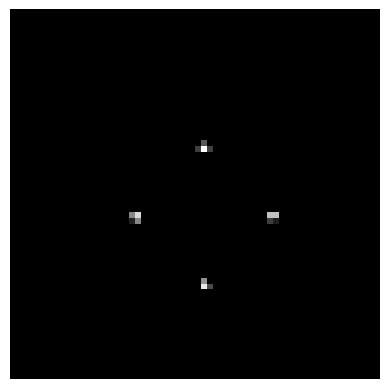

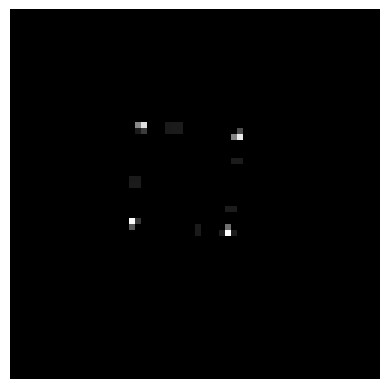

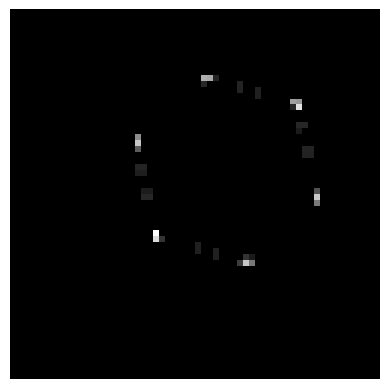

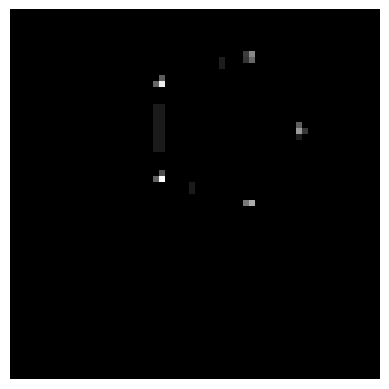

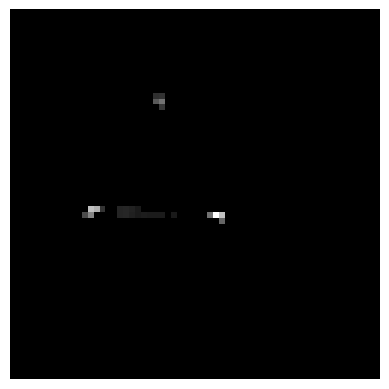

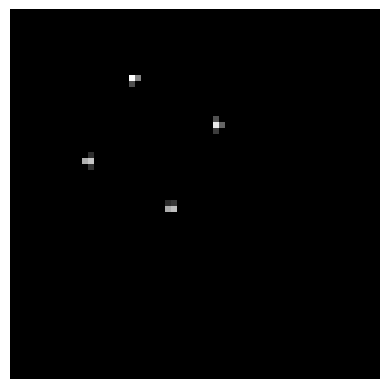

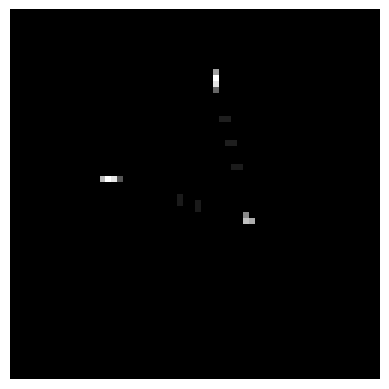

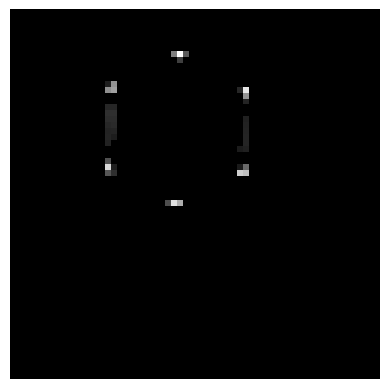

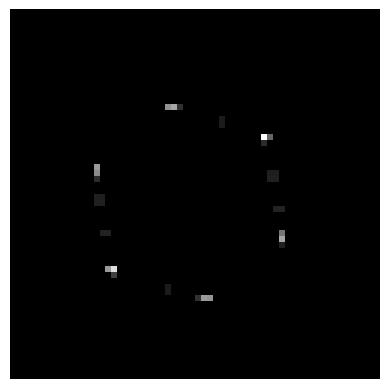

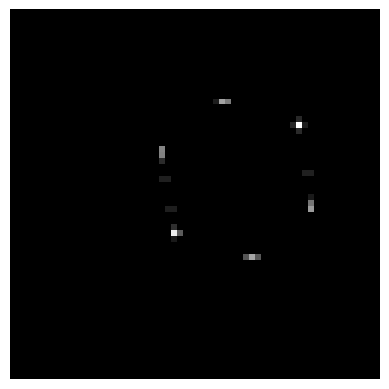

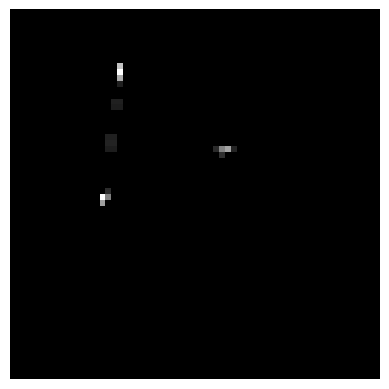

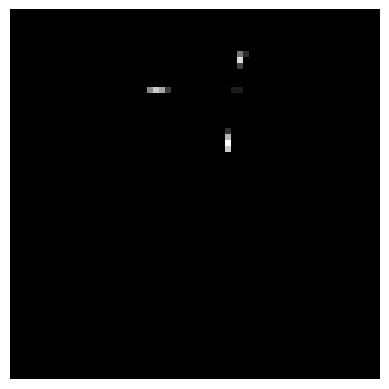

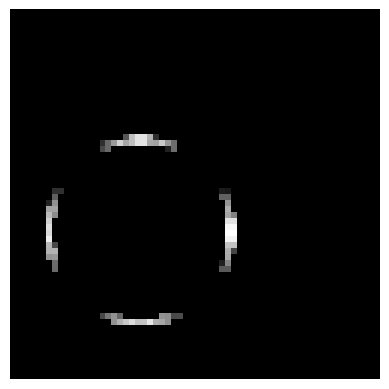

In [ ]:
X_processed = numpy_preprocessing(X_train[0:150])
for i in range(120,150):
  np.max(X_processed[i])
  plot(X_processed[i])
  plt.show()

In [ ]:
def tf_preprocessing_wrapper(input_tensor):
    # Process the input tensor with the numpy_preprocessing function
    processed_tensor = tf.py_function(numpy_preprocessing, [input_tensor], Tout=tf.float32)

    # Explicitly set the shape of the processed_tensor to include the channel dimension
    input_tensor.set_shape([None, 62, 62, 1])  # Assuming each image is 50x50 with 1 channel

    return processed_tensor


In [ ]:
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import ZeroPadding2D



# model

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_19 (ZeroPad  (None, 56, 56, 1)         0         
 ding2D)                                                         
                                                                 
 conv2d_39 (Conv2D)          (None, 53, 53, 128)       2176      
                                                                 
 batch_normalization_61 (Ba  (None, 53, 53, 128)       512       
 tchNormalization)                                               
                                                                 
 activation_61 (Activation)  (None, 53, 53, 128)       0         
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 26, 26, 128)       0         
 ng2D)                                                           
                                                     

In [360]:
model = tf.keras.Sequential([
    # tf.keras.layers.Lambda(tf_preprocessing_wrapper),  # Custom preprocessing
    #ZeroPadding2D(padding=(3, 3), input_shape=(50, 50, 1)),  # padding=(3, 3) adds 3 rows/columns of zeros on each side

    # Convolutional Layer followed by Batch Normalization
    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), use_bias=True,  input_shape=(50, 50, 1)),  # Set use_bias=False
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    # Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), use_bias=True),  # Set use_bias=False
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    # Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    # Flatten the output for the Dense layers
    tf.keras.layers.Flatten(),

    # Dense Layer followed by Batch Normalization
    tf.keras.layers.Dense(128, use_bias=True, kernel_regularizer=l2(0.01)),  # Set use_bias=False
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.2),

    # Dense Layer followed by Batch Normalization
    tf.keras.layers.Dense(32, use_bias=True, kernel_regularizer=l2(0.01)),  # Set use_bias=False
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.2),
    # Output Layer
    tf.keras.layers.Dense(5, activation='softmax') # Adjust according to your task
])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [361]:
# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.00007) # Set your desired learning rate

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# 3. Train the Model
num_epochs=40
history= model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_split=0.2)


Epoch 1/40
241/241 [==============================] - 5s 20ms/step - loss: 0.2058 - accuracy: 0.9831 - val_loss: 0.2752 - val_accuracy: 0.9745
Epoch 2/40
241/241 [==============================] - 3s 12ms/step - loss: 0.1806 - accuracy: 0.9894 - val_loss: 0.2439 - val_accuracy: 0.9829
Epoch 3/40
241/241 [==============================] - 3s 11ms/step - loss: 0.1869 - accuracy: 0.9851 - val_loss: 0.2358 - val_accuracy: 0.9829
Epoch 4/40
241/241 [==============================] - 3s 13ms/step - loss: 0.1744 - accuracy: 0.9871 - val_loss: 0.2283 - val_accuracy: 0.9839
Epoch 5/40
238/241 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9845

In [ ]:
pred = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))
true_classes = y_test

62/62 [==============================] - 0s 4ms/step
Accuracy on test set - 97.70%


In [366]:
pred = model.predict(X).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y).mean()))
true_classes = y


306/306 [==============================] - 1s 3ms/step
Accuracy on test set - 99.27%


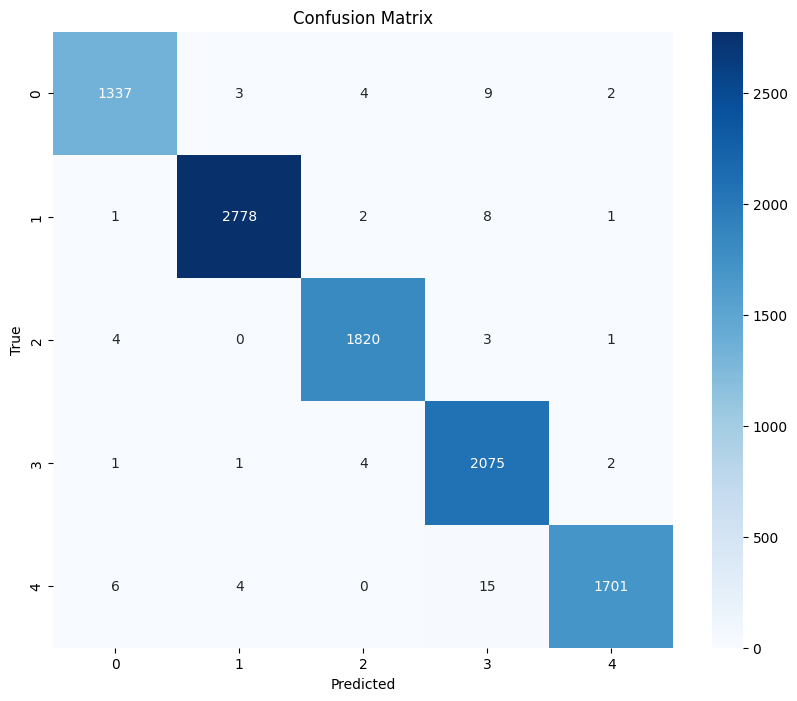

In [368]:
  # Use directly if y_test is already integer labels


# Create the confusion matrix
cm = confusion_matrix(true_classes, pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
misclassified_indices = np.where(pred != true_classes)[0]
misclassified_indices.shape

(98,)

In [ ]:
def bad_shapes(k):
  bad=[]
  for i in misclassified_indices:
    if pred[i] == k:
      bad.append(i)

  print(bad)

In [ ]:
bad_shapes(3)

[3745, 6655]


In [ ]:
1460, 2651, 5484, 6572, 6994, 7830, 9418, 688, 4983, 6352, 7223, 8497, 9052, 672, 2782, 3053, 3757, 4216, 4423, 5340, 5912, 7440, 8450, 8493]



(3082,
 5004,
 8533,
 9090,
 673,
 2729,
 2790,
 3064,
 3769,
 4232,
 4442,
 8484,
 8529,
 8815)

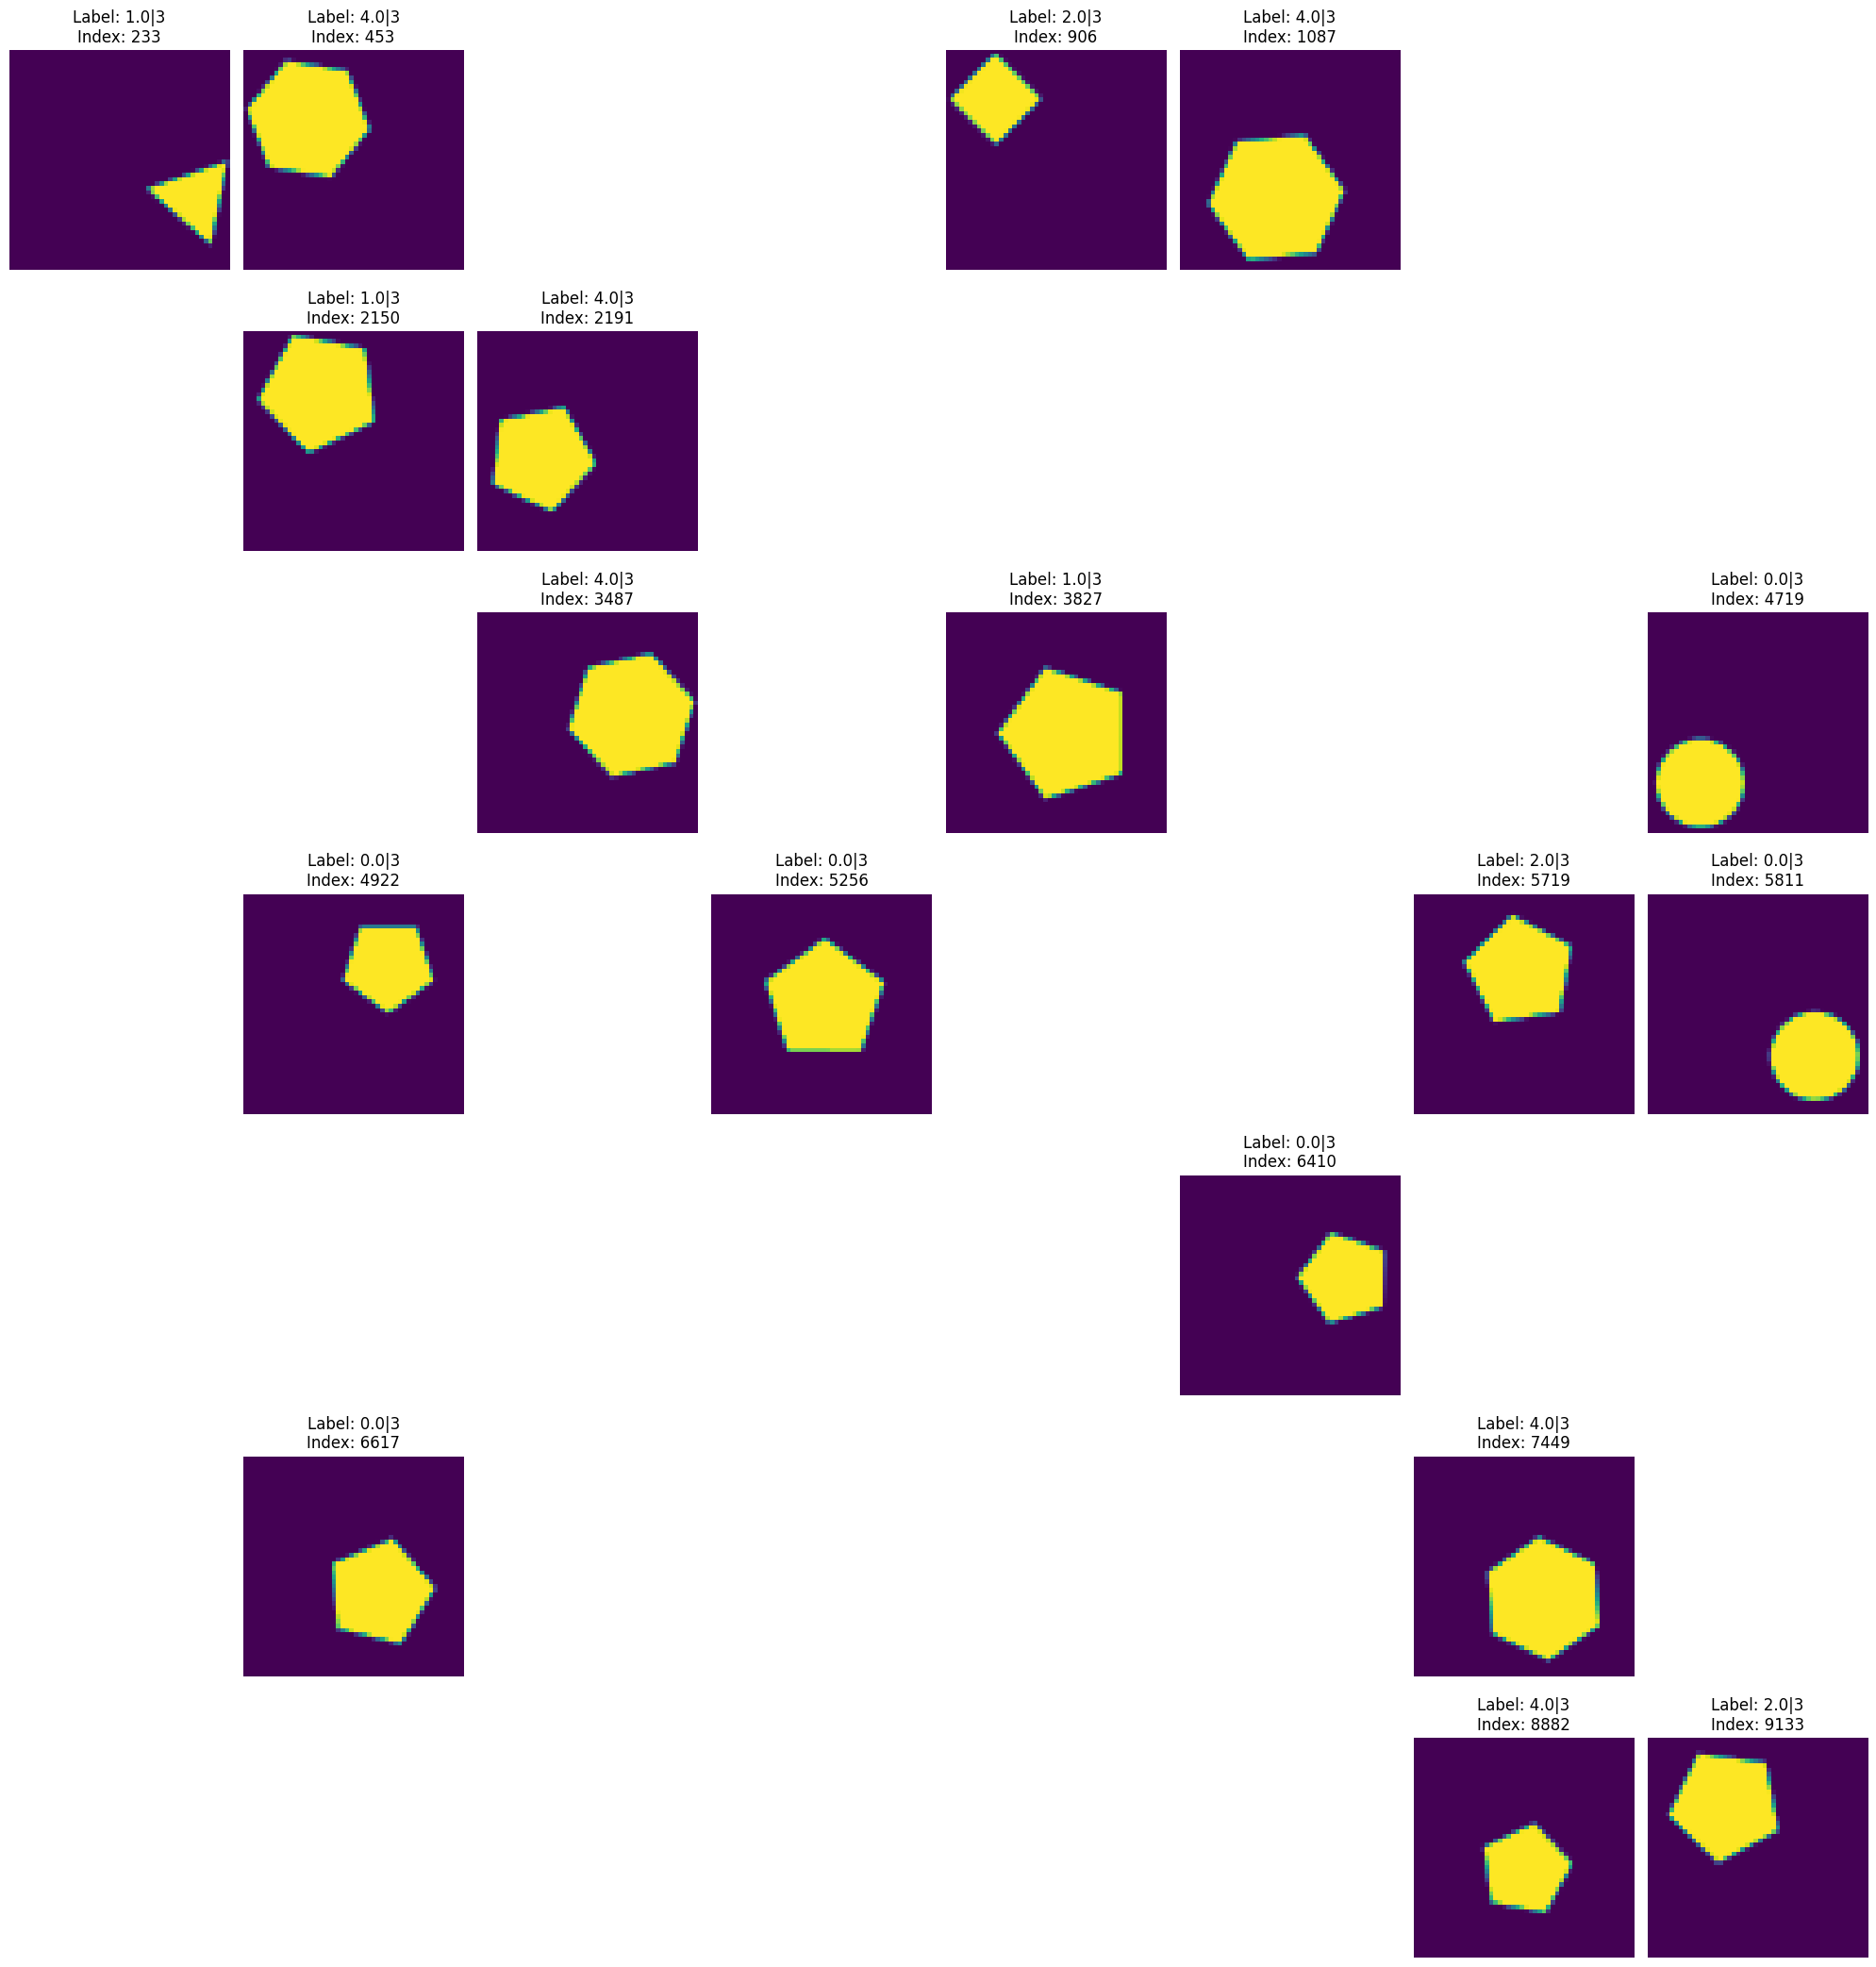

In [357]:
misclassified_indices = np.where(pred != true_classes)[0]
# Define the number of images you want to display
# Set the number of subplots you want
# Number of columns
num_columns = 8

# Calculate the number of rows needed
num_rows = math.ceil(len(misclassified_indices) / num_columns)

# Create a figure with the calculated number of rows and columns
plt.figure(figsize=(20, 3 * num_rows))

# Loop over the elements in misclassified_indices
for idx, i in enumerate(misclassified_indices):
    # Calculate the position of the current subplot
    row = idx // num_columns + 1
    col = idx % num_columns + 1

    # Create a subplot at the calculated position
    if pred[i] == 3:
      plt.subplot(num_rows, num_columns, row * num_columns - num_columns + col)
      plt.imshow(X[i])  # plot the image at index i
      plt.title(f"Label: {y[i]}|{pred[i]}\nIndex: {i}")
      plt.axis('off')  # turn off axis

plt.tight_layout()
plt.show()




In [ ]:
[672, 2782, 3053, 3757, 4216, 4423, 5340, 5912, 7440, 8450, 8493]


In [ ]:
# Assuming 'model' is your Keras model
model.save('my_model_13.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(pred[1385])
y[1385]

4


4.0

In [ ]:
[619, ]

Text(0.5, 1.0, '3.0')

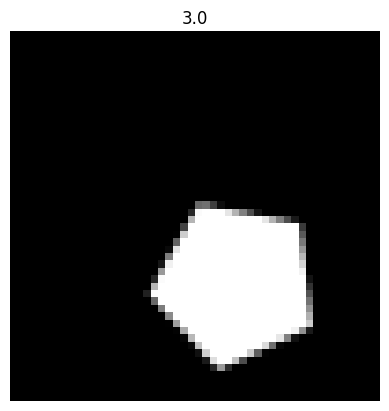

In [ ]:
plot(X[142])
plt.title(y[142])

In [ ]:
pri

In [ ]:
print(misclassified_indices)

[ 142  255  300  619  645  686  838  882  895 1056 1163 1186 1187 1263
 1267 1385 1398 1452 1455 1489 1506 1571 1583 1621 1681 1738 1804 1813
 1903 1938]


1/1 [==============================] - 0s 118ms/step


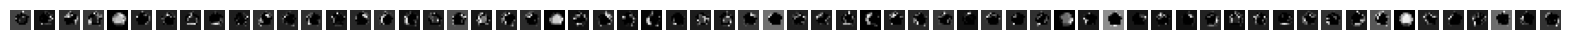

In [ ]:
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.layers[8].output)
input_image = X_test[7]  # Assuming X_train is your dataset
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
pooling_layer_output = intermediate_model.predict(input_image)
# Number of feature maps
num_feature_maps = pooling_layer_output.shape[-1]

# Visualize each feature map
fig, axarr = plt.subplots(1, num_feature_maps, figsize=(20, 20))
for i in range(num_feature_maps):
    axarr[i].imshow(pooling_layer_output[0, :, :, i], cmap='gray')
    axarr[i].axis('off')
plt.show()

In [ ]:
min(pred)

1

In [ ]:
# Print the comparison
for actual, predicted in zip(y_test, pred):
    print(f"Actual: {actual}, Predicted: {predicted}")  # Adjust indexing based on your output shape


1/1 [==============================] - 0s 178ms/step


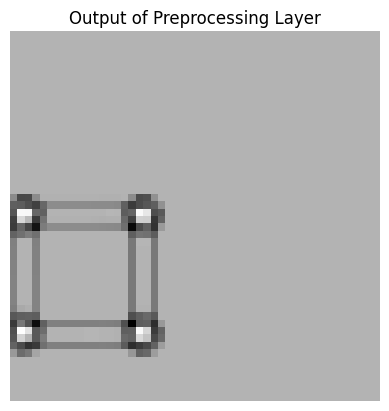

1/1 [==============================] - 0s 219ms/step


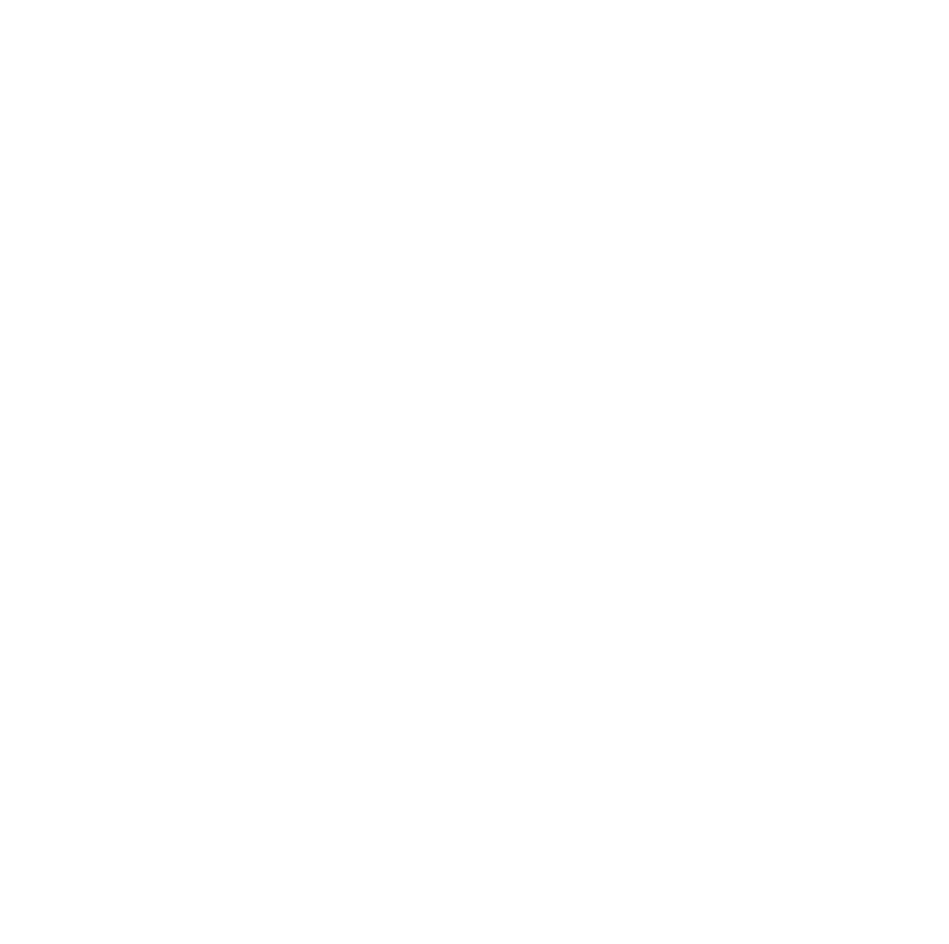

1/1 [==============================] - 0s 140ms/step


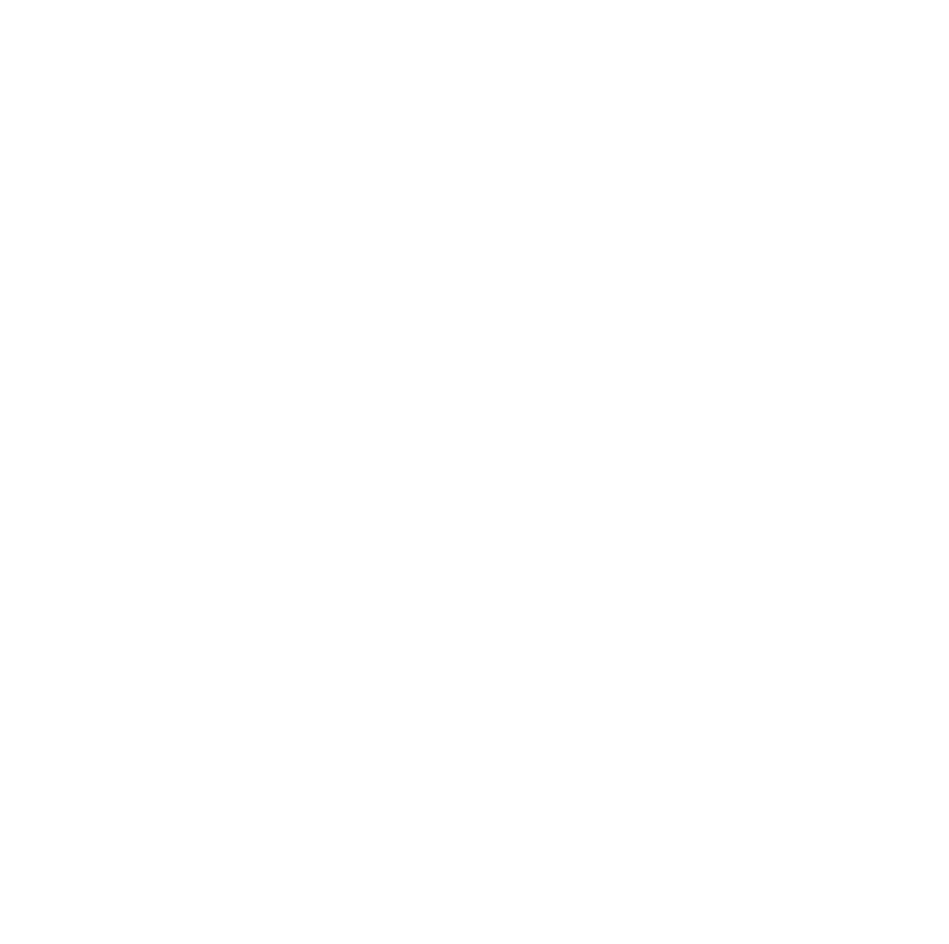

In [ ]:
i = 57
# Assuming 'model' is your existing model
preprocessing_model = tf.keras.Model(inputs=model.input,
                                     outputs=model.layers[0].output)
# Example: Preparing a sample input (adjust as per your input data format)
sample_input = X_train[i]  # Choose a sample from your training data
sample_input = np.expand_dims(sample_input, axis=0)  # Add batch dimension
preprocessed_output = preprocessing_model.predict(sample_input)

# Assuming the output is an image
plt.imshow(preprocessed_output[0], cmap='gray')  # Adjust colormap as needed
plt.title("Output of Preprocessing Layer")
plt.axis('off')
plt.show()


conv_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[1].output)
# Example: Preparing an input image (adjust as per your input data format)
input_image = X_train[i]  # Choose a sample from your training data
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
feature_maps = conv_layer_model.predict(input_image)

# Number of feature maps to visualize
num_feature_maps = feature_maps.shape[-1]

# Set the number of columns for the subplot
num_columns = 6
num_rows = num_feature_maps // num_columns + 1

plt.figure(figsize=(num_columns * 2, num_rows * 2))

for i in range(num_feature_maps):
    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')  # Adjust colormap if needed
    plt.axis('off')

plt.show()


second_conv_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[3].output)

# Prepare an input image (assuming X_train is your dataset and images are grayscale)
# Select a sample and add a batch dimension
input_image = X_train[i]  # Select a sample from your training data
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Generate feature maps
feature_maps = second_conv_layer_model.predict(input_image)

# Number of feature maps
num_feature_maps = feature_maps.shape[-1]

# Define the number of columns for displaying the feature maps
num_columns = 6
num_rows = num_feature_maps // num_columns + 1

plt.figure(figsize=(num_columns * 2, num_rows * 2))

for i in range(num_feature_maps):
    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')  # Adjust colormap as needed
    plt.axis('off')

plt.show()



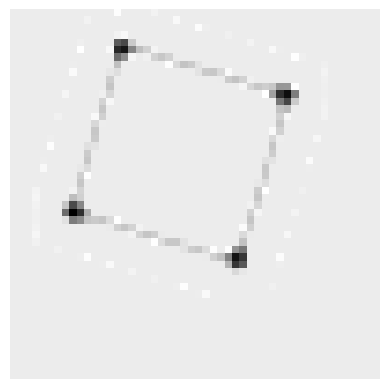

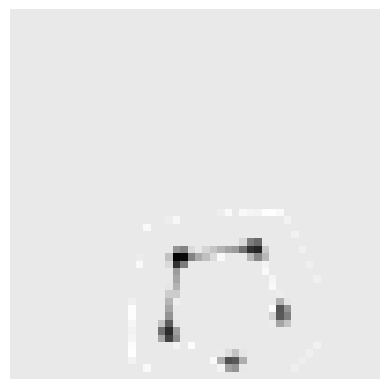

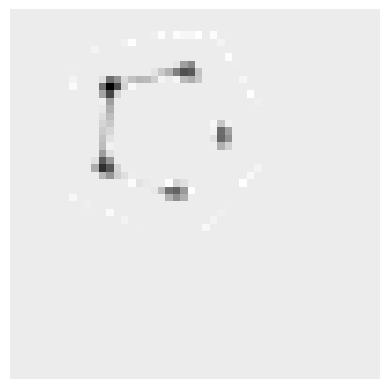

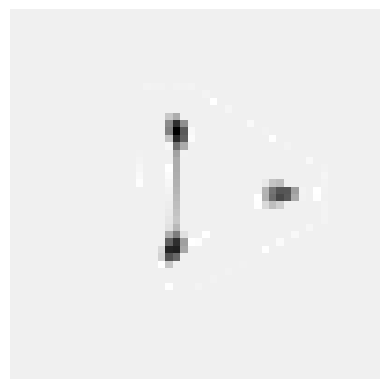

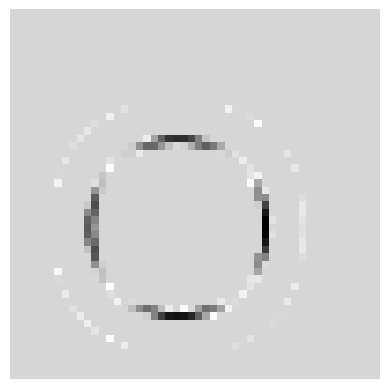

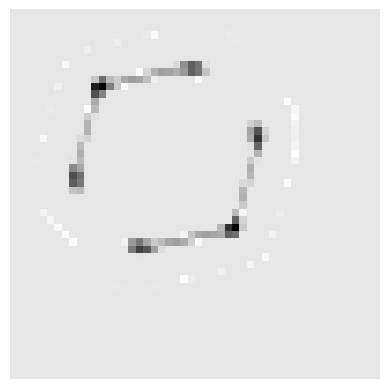

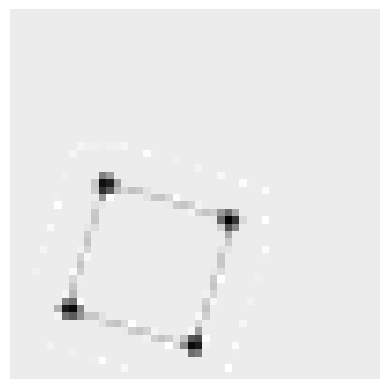

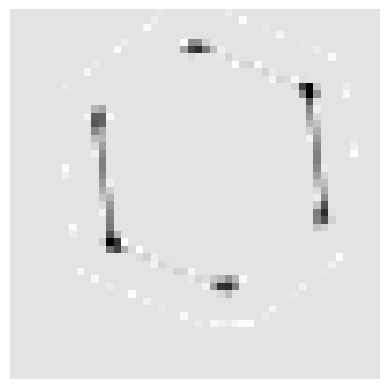

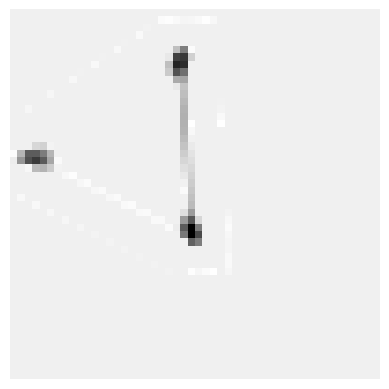

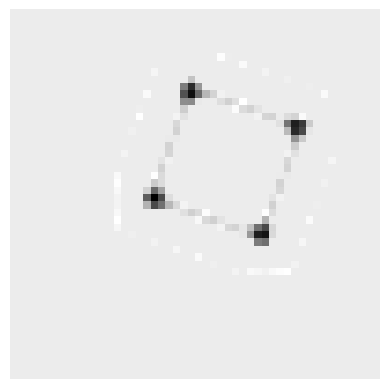

In [ ]:
indices = np.where(y >= 0)[0]

# Now, randomly select 10 indices from this filtered list
# Adjust the size parameter according to the number of available indices
random_indices = np.random.choice(indices, size=min(10, len(indices)), replace=False)


for i in random_indices:
  #plot(X[i])
  plt.show()
  plt.axis('off')
  plt.imshow(filter(sum_disk(X[i]), 0.07), cmap='gray')
  #apply_filter(pad7(X[i]), F).shape
  plt.show()


In [ ]:
def build_model:
  model = Sequeantial()
